In [11]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
hv.extension()

In [12]:
def polanyi_wigner(T, init_coverage, Edes, beta, order, nu=None, disp=False):
    # TODO unpack orders if multiple are given as args
    R = 8.314  # j/molK
    order_dict = {0: 1e28, 0.5: 3e20, 1: 1e13, 2: 1e-2}
    if nu is None:
        nu  = order_dict.get(order,1e13)
    dNdT = np.zeros((T.shape[0], len(init_coverage)))

    coverage_lst = np.zeros((T.shape[0], len(init_coverage)))

    # for looping over multiple coverages
    for idx1, coverage in enumerate(init_coverage):
        # for a particular coverage, loop over T
        for idx, val in enumerate(T):


            # TODO: issue for zero order in that at some point coverage = 0 but the exp decreases as T increases
            dNdT[idx][idx1] = nu/(beta)*(coverage**order)*np.exp(-Edes/(R*val))
            # print(dNdT[idx][idx1])
            # dNdT[idx][idx1] = nu/(beta)*(np.float_power(coverage,order))*np.exp(-Edes/(R*val))

            # this may be needed for debugging:
            # if idx % 5 == 0:
            #     print(dNdT[idx][idx1])
            #     print('nu: {0}, \nbeta: {1},\ncoverage: {2},\nexp term: {3}, \nT: {4}'
            #           .format(nu, beta, coverage,np.exp(-Edes / (R * val)), val))
            if coverage <= 0:
                coverage = 0
                dNdT[idx][idx1] = 0
                coverage_lst[idx][idx1] = coverage
            else:
                coverage_lst[idx][idx1] = coverage
                coverage -= val*dNdT[idx][idx1]

    fig, ax = plt.subplots()
    ax.plot(T, dNdT)
    plt.xlabel('Temperature')
    plt.ylabel('dN/dT')
    fig1, ax1 = plt.subplots()
    ax1.plot(T, coverage_lst)

    # # test
    # fig2, ax2 = plt.subplots()
    # cov = np.array(coverage_lst)
    # out = cov[:,np.newaxis]*dNdT
    # ax2.plot(T,out)
    if disp is True:
        plt.show()
    else:
        return


    # assert len(out) == len(T)
    # fig2, ax2 = plt.subplots()
    # ax2.plot(T,out)

    # return hv.Curve(polanyi_wigner(T, init_coverage, Edes, beta, order, nu))
    return

In [19]:
order = 0
Edes = 30e3 #j/mol, a good value is 50e3
T = np.arange(1,500,3)
initial_coverage=[1e15, 5e14, 2e14]
# initial_coverage=[2e14]
beta = 3

<IPython.core.display.Javascript object>


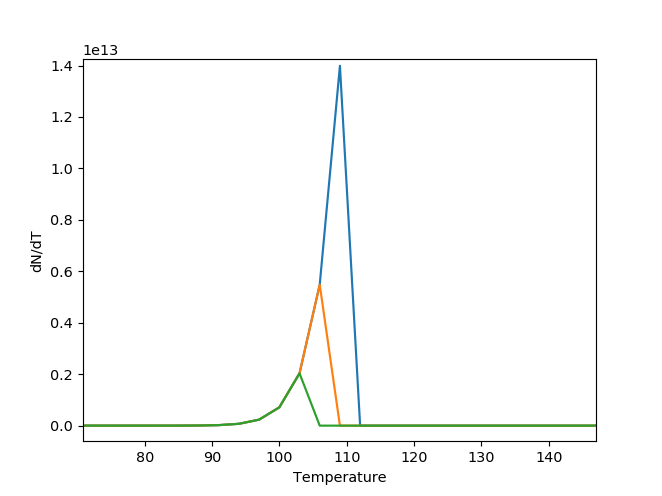

<IPython.core.display.Javascript object>


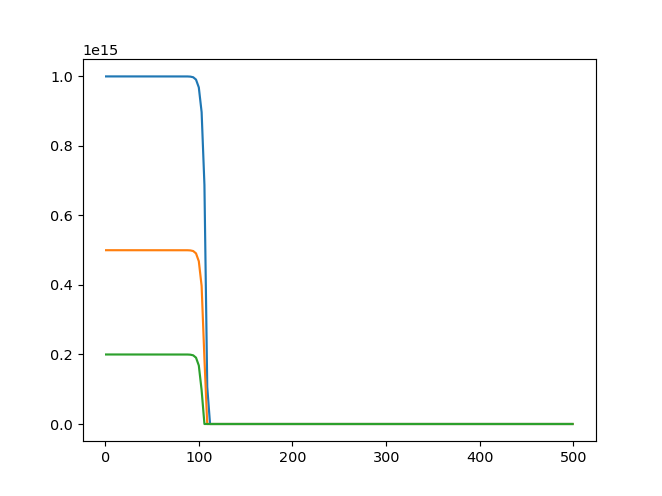

In [20]:
out = polanyi_wigner(T, initial_coverage, Edes, beta, order, disp=True)